In [1]:
!pip install torchsummary
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 1.8 MB/s eta 0:00:00


In [2]:
!pip install albumentations

In [3]:
from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
import wandb

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.transforms import RandomGamma

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# import tensorflow as tf
# from tensorflow.compat.v1 import InteractiveSession

# tf.keras.backend.clear_session()
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9953165e-0e31-26cf-b40d-96f3f83f8b17)
GPU 1: Tesla T4 (UUID: GPU-59167f3a-11af-a34a-65c7-735b8f1eb6fd)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
num_classes = 3

# Number of epoch
epochs = 30

# Hyperparameters for training 
learning_rate = 2e-04
batch_size = 4
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/unet-checkpoint/unet_model.pth"
# Initialize lists to keep track of loss and accuracy
loss_epoch_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

In [8]:
class TrainTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomGamma(gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
            A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
            A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(),
                    A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
            A.CoarseDropout(p=0.2, max_height=35, max_width=35, fill_value=255),
            A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
            A.RandomShadow(p=0.1),
            A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
            A.Resize(256, 256, interpolation=cv2.INTER_LINEAR),
            A.Normalize(),
            ToTensorV2(),
        ])

    def __call__(self, img, mask):
        return self.transform(image=img, mask=mask)


class ValTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    def __call__(self, img, mask):
        return self.transform(image=img, mask=mask)


class TestTransform:
    def __init__(self):
        self.transform = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    def __call__(self, img):
        return self.transform(image=img)['image']

In [9]:
class UnetDataClass(Dataset):
    def __init__(self, image_dir,mask_dir = [],mode = "train"):
        super(UnetDataClass, self).__init__()
        self.mode = mode
        if mode == "train":
            self.train_path = image_dir
            self.train_mask_path = mask_dir
            self.len = len(self.train_path)
            self.train_transform = TrainTransform()
        elif mode == "valid":
            self.val_path = image_dir
            self.val_mask_path = mask_dir
            self.len = len(self.val_path)
            self.val_transform = ValTransform()
        elif mode == "test":
            self.test_path = image_dir
            self.len = len(self.test_path)
            self.test_transform = TestTransform()

            
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image = cv2.resize(image, (256,256))
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160, 100, 20])
        upper2 = np.array([179, 255, 255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)

        red_mask = lower_mask + upper_mask
        red_mask[red_mask != 0] = 1

        # boundary GREEN color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = full_mask.astype(np.uint8)
        return full_mask


    def __getitem__(self, index: int):
        if self.mode == "train":
            image = cv2.imread(self.train_path[index])
            image = cv2.resize(image, (256,256))
            mask = self.read_mask(self.train_mask_path[index])
            return self.train_transform(image, mask)
        elif self.mode == "valid":
            image = cv2.imread(self.val_path[index])
            image = cv2.resize(image, (256,256))
            mask = self.read_mask(self.val_mask_path[index])
            return self.val_transform(image, mask)
        elif self.mode == "test":
            image = cv2.imread(self.test_path[index])
            H, W, _ = image.shape
            image = cv2.resize(image, (256,256))
            image = self.test_transform(image)
            
            file_name = self.test_path[index].split('/')[-1].split('.')[0]
            return  image, file_name,H, W
        
    def __len__(self):
        return self.len

In [10]:
image_path = []
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
for root, dirs, files in os.walk(images_path):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)

mask_path = []
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"
for root, dirs, files in os.walk(masks_path):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)

In [11]:
train_ratio = 0.8
valid_ratio = 0.2

In [12]:
import random

shuffle_list = list(zip(image_path, mask_path))
random.shuffle(shuffle_list)
image_path, mask_path = zip(*shuffle_list)

In [13]:
train_size = int(train_ratio * len(image_path))
train_path = image_path[:train_size]
train_mask_path = mask_path[:train_size]
val_path = image_path[train_size:]
val_mask_path = mask_path[train_size:]
train_dataset = UnetDataClass(train_path, train_mask_path, mode="train")
val_dataset = UnetDataClass(val_path, val_mask_path, mode="valid")

In [14]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [15]:
print(train_loader.dataset.__getitem__(7)['mask'])
print(train_loader.dataset.__getitem__(7)['mask'].shape)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
torch.Size([256, 256])


In [16]:
print(val_loader.dataset.__getitem__(7)['image'])
print(val_loader.dataset.__getitem__(7)['image'].shape)

tensor([[[-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.0152,  ..., -2.1008, -2.1008, -2.1008],
         ...,
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],

        [[-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -1.9307,  ..., -2.0182, -2.0182, -2.0182],
         ...,
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],

        [[-1.7870, -1.7870, -1.7870,  ..., -1.7870, -1.7870, -1.7870],
         [-1.7870, -1.7870, -1.7870,  ..., -1

# BUILD MODELS

In [17]:
!pip install segmentation-models-pytorch

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.9 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

# NORMAL CODE

# Encoder

In [18]:
# class encoder_block(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(encoder_block, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.bn2 = nn.BatchNorm2d(out_channels)
        
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.3)
#         self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
        
#         x = self.dropout(x)
        
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
        
#         next_layer = self.max_pool(x)
#         skip_layer = x
        
#         return next_layer, skip_layer

# Decoder

In [19]:
# class decoder_block(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(decoder_block, self).__init__()
        
#         self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
#         self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.bn2 = nn.BatchNorm2d(out_channels)
        
#         self.relu = nn.ReLU() 
#         self.dropout = nn.Dropout(p=0.3)
    
#     def forward(self, x, skip_layer):
#         x = self.transpose_conv(x)
#         x = torch.cat([x, skip_layer], axis=1)
        
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
        
#         x = self.dropout(x)
        
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
        
#         return x

# Bottleneck

In [20]:
# class bottleneck_block(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(bottleneck_block, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.bn2 = nn.BatchNorm2d(out_channels)
        
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.3)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
        
#         x = self.dropout(x)
        
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
        
#         return x

# Build Normal Unet

In [21]:
# # UNet model
# class UNet(nn.Module):
#     def __init__(self, n_class=3):
#         super(UNet, self).__init__()
#         # Encoder blocks
#         self.enc1 = encoder_block(3, 64)
#         self.enc2 = encoder_block(64, 128)
#         self.enc3 = encoder_block(128, 256)
#         self.enc4 = encoder_block(256, 512)
        
#         # Bottleneck block
#         self.bottleneck = bottleneck_block(512, 1024)
        
#         # Decoder blocks
#         self.dec1 = decoder_block(1024, 512)
#         self.dec2 = decoder_block(512, 256)
#         self.dec3 = decoder_block(256, 128)
#         self.dec4 = decoder_block(128, 64)
        
#         # 1x1 convolution
#         self.out = nn.Conv2d(64, n_class, kernel_size=1, padding='same')
        
#     def forward(self, image):
#         n1, s1 = self.enc1(image)
#         n2, s2 = self.enc2(n1)
#         n3, s3 = self.enc3(n2)
#         n4, s4 = self.enc4(n3)
        
#         n5 = self.bottleneck(n4)
        
#         n6 = self.dec1(n5, s4)
#         n7 = self.dec2(n6, s3)
#         n8 = self.dec3(n7, s2)
#         n9 = self.dec4(n8, s1)
        
#         output = self.out(n9)
        
#         return output

# ResUnet

In [22]:
import torch
import torch.nn as nn
import torchvision

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )

class ResNetUNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

# Cross-Entropy DiceLoss Function

In [23]:
class CEDiceLoss(nn.Module):
    def __init__(self, weights) -> None:
        super(CEDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))
        if not self.weights.shape[1] == input.shape[1]:
            raise ValueError("The number of weights must equal the number of classes")
        if not torch.sum(self.weights).item() == 1:
            raise ValueError("The sum of all weights must equal 1")
            
        # cross entropy loss
        celoss = nn.CrossEntropyLoss(self.weights)(input, target)
        
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # create the labels one hot tensor
        target_one_hot = one_hot(target, num_classes=input.shape[1],
                                 device=input.device, dtype=input.dtype)

        # compute the actual dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        
        dice_score = torch.sum(dice_score * self.weights, dim=1)
        
        return torch.mean(1. - dice_score) + celoss

# Weight Init

In [24]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

# Load and Save Model

In [25]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

# Trainer Setup

In [26]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, load in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = load['image'].to(device), load['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for load in valid_dataloader:
            data, target = load['image'].to(device), load['mask'].to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target.long())
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= (i+1)
    
    return train_loss_epoch , test_loss_epoch

# Test Setup

In [27]:
# Test function
def test(dataloader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i,load in enumerate(dataloader):
            data, targets = load['image'].to(device), targets.to(device)
            outputs = model(data)
            _, pred = torch.max(outputs, 1)
            test_loss += targets.size(0)
            correct += torch.sum(pred == targets).item()
    return 100.0 * correct / test_loss

# UnetPlusPlus

In [28]:
torch.cuda.empty_cache()
# model = UNet(3)
import segmentation_models_pytorch as smp
model = smp.UnetPlusPlus(
    encoder_name="resnet34",      
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=3                       
)

model = nn.DataParallel(model)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 139MB/s]


DataParallel(
  (module): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

# ResUnet

In [29]:
# model = ResNetUNet(n_classes = 3)
# model.to(device)

# Normal Unet

In [30]:
# model = UNet()
# model.apply(weights_init)
# # model = nn.DataParallel(model)
# #checkpoint = torch.load(pretrained_path)

# #new_state_dict = OrderedDict()
# #for k, v in checkpoint['model'].items():
# #    name = k[7:] # remove `module.`
# #    new_state_dict[name] = v
# # load params
# #model.load_state_dict(new_state_dict)
# model = nn.DataParallel(model)
# model.to(device)

In [31]:
weights = torch.Tensor([[0.4, 0.55, 0.05]]).cuda()
loss_function = CEDiceLoss(weights)

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
#optimizer.load_state_dict(checkpoint['optimizer'])

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.6)

In [32]:
save_model(model, optimizer, checkpoint_path)

In [33]:
wandb.login(
    key = "4184ad0bd316668aed39d30ad508ca2d23ef0479",
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [34]:
wandb.init(
    project = "Polyps_Segmentation_3"
)
# Training loop
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_loader, 
                                              val_loader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})
#     train_accuracy.append(test(train_loader))
#     valid_accuracy.append(test(test_loader))
#     print("Epoch {}: loss: {:.4f}, train accuracy: {:.4f}, valid accuracy:{:.4f}".format(epoch + 1, 
#                                         train_loss_array[-1], train_accuracy[-1], valid_accuracy[-1]))

wandb: Currently logged in as: congquyk66hust (helarica). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231117_112428-wgilnsd2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run celestial-dust-9
wandb: ⭐️ View project at https://wandb.ai/helarica/Polyps_Segmentation_3
wandb: 🚀 View run at https://wandb.ai/helarica/Polyps_Segmentation_3/runs/wgilnsd2


Start epoch #1, learning rate for this epoch: [0.0002]
Train Epoch: 1 [200/800 (25.0%)]	Loss: 0.9714
Train Epoch: 1 [400/800 (50.0%)]	Loss: 0.6571
Train Epoch: 1 [600/800 (75.0%)]	Loss: 0.4473
Train Epoch: 1 [800/800 (100.0%)]	Loss: 0.4889
Done epoch #1, time for this epoch: 77.73257112503052s
Start epoch #2, learning rate for this epoch: [0.0002]
Train Epoch: 2 [200/800 (25.0%)]	Loss: 0.7320
Train Epoch: 2 [400/800 (50.0%)]	Loss: 0.7336
Train Epoch: 2 [600/800 (75.0%)]	Loss: 0.3258
Train Epoch: 2 [800/800 (100.0%)]	Loss: 0.4655
Done epoch #2, time for this epoch: 54.53241586685181s
Start epoch #3, learning rate for this epoch: [0.0002]
Train Epoch: 3 [200/800 (25.0%)]	Loss: 0.4190
Train Epoch: 3 [400/800 (50.0%)]	Loss: 0.4419
Train Epoch: 3 [600/800 (75.0%)]	Loss: 0.3735
Train Epoch: 3 [800/800 (100.0%)]	Loss: 0.3565
Done epoch #3, time for this epoch: 55.362605571746826s
Start epoch #4, learning rate for this epoch: [0.0002]
Train Epoch: 4 [200/800 (25.0%)]	Loss: 0.6008
Train Epoch: 

In [35]:
# torch.cuda.empty_cache()

In [36]:
# load_model(model, checkpoint)

In [37]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 4)
epochs_array = range(epochs)

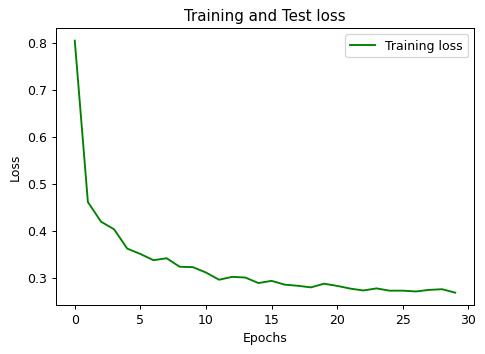

In [38]:
# Plot Training and Test loss
plt.plot(epochs_array, train_loss_array, 'g', label='Training loss')
# plt.plot(epochs_array, test_loss_array, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# from torch.jit import load
# model = UNet()
# optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# checkpoint = torch.load(pretrained_path)

In [40]:
# optimizer.load_state_dict(checkpoint['optimizer'])

In [41]:
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint['model'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)

In [42]:
for i, load in enumerate(train_loader):
    img = load['image']
    mask = load['mask']
    break

In [43]:
test_path = []
tests_path = "/kaggle/input/bkai-igh-neopolyp/test/test/"
for root, dirs, files in os.walk(tests_path):
    for file in files:
        path = os.path.join(root,file)
        test_path.append(path)
len(test_path)

200

In [44]:
unet_test_dataset = UnetDataClass(test_path, mode = "test")
# unet_test_dataset = UNetTestDataClass(test_path, mode = "test")
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=False)

In [45]:
unet_test_dataset.__getitem__(7)[0].shape

torch.Size([3, 256, 256])

In [46]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break

In [47]:
model.eval()
def mask2rgb(mask):
    color_dict = {0: torch.tensor([0, 0, 0]),
                  1: torch.tensor([1, 0, 0]),
                  2: torch.tensor([0, 1, 0])}
    output = torch.zeros((mask.shape[0], mask.shape[1], 3)).long()
    for k in color_dict.keys():
        output[mask.long() == k] = color_dict[k]
    return output.to(mask.device)

if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        argmax = torch.argmax(predicted_mask[i], 0)
        one_hot = mask2rgb(argmax).float().permute(2, 0, 1)
        mask2img = Resize((H[i].item(), W[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(one_hot))
#         mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))

In [48]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'submission.csv', index=False)

/kaggle/working/predicted_masks/285e26c90e1797c77826f9a7021bab9f.png
/kaggle/working/predicted_masks/1c0e9082ea2c193ac8d551c149b60f29.png
/kaggle/working/predicted_masks/7af2ed9fbb63b28163a745959c039830.png
/kaggle/working/predicted_masks/39d6aad6bb0170a40ed32deef71fbe08.png
/kaggle/working/predicted_masks/dd78294679c9cbb2a365b5574868eb60.png
/kaggle/working/predicted_masks/6ddca6ee1af35b65bd9ea42cfcfedb5e.png
/kaggle/working/predicted_masks/5b21960c94b0aab4c024a573c692195f.png
/kaggle/working/predicted_masks/d6240619ebebe9e9c9d00a4262b4fe4a.png
/kaggle/working/predicted_masks/8954bb13d3727c7e5e1069646f2f0bb8.png
/kaggle/working/predicted_masks/94a7f32574d6c748c41743c6c08a1d1a.png
/kaggle/working/predicted_masks/f7fdb2d45b21960c94b0aab4c024a573.png
/kaggle/working/predicted_masks/0619ebebe9e9c9d00a4262b4fe4a5a95.png
/kaggle/working/predicted_masks/4ef4d95ceea11957998906d3694abb47.png
/kaggle/working/predicted_masks/05b78a91391adc0bb223c4eaf3372eae.png
/kaggle/working/predicted_masks/0a